In [1]:
from pfp_stat import *

import numpy as np
import pandas as pd 

import pandas_datareader.data as web
import matplotlib.pyplot as plt
import matplotlib

import datetime as dat

from pylab import title, figure, xlabel, ylabel, xticks, bar, legend, axis, savefig
from fpdf import FPDF
import fpdf

from pfp_products import *

import os.path
from scipy.optimize import minimize

In [2]:
print('Okay, lets see what we have here.')

prodcat_filename = 'inputs/prod_cat open.xlsx'
prodcat_sheetname = 'prod cat'

xls = pd.read_excel(prodcat_filename, prodcat_sheetname, 
                         decimal = '.', usecols = 'b:z', 
                         index_col = 0, header = 1)

print('I`m using `' + prodcat_sheetname + '` sheet of `' + prodcat_filename + '` file as product catalog.')

products = xls.transpose()
all_BAs = []
prod_list = []
max_term = 0

for prod, row in products.iterrows():
    
    check = check_stat(row.BAs)
    
    if check:        
        all_BAs.extend(row.BAs.split(', '))
        all_BAs = list(set(all_BAs))
        
        if row.term > max_term: max_term = row.term

        Note1 = Structure(prod, row.BAs, row.notional_curr, row.term, 
                  row.coupon_value, row.coupon_always, row.coupon_check_months, row.coupon_memory, 
                  row.coupon_lower_barrier, row.coupon_upper_barrier,
                  row.autocall_flag, row.autocall_check_months, row.autocall_barrier, row.autocall_barrier_increase_rate,
                  row.redemption_amount, row.redemption_put_strike, row.redemption_guarantee_rule,
                  row.redemption_upside_participation, row.redemption_downside_participation, row.issuer)
        Note1.stats_ok = True
        
        prod_list.append(Note1)
    else: 
        print ('We dont have enough statistics for ' + row.name + ' underlyings. We do not calculate it now.')

print('...')
print('All products from `prod cat.xls` except mentioned above are successfully loaded.')

Okay, lets see what we have here.
I`m using `prod cat` sheet of `inputs/prod_cat open.xlsx` file as product catalog.
...
All products from `prod cat.xls` except mentioned above are successfully loaded.


In [3]:
n_scenarios = 50000
simulation_years = max_term   

returns = ba_scenarios(all_BAs, 
                       simulation_years,  
                       n_scenarios, 
                       print_statistics = True,
                       points_in_year = 12)
print('Scenarios ready!')

Returns: 
gmkn rx equity    0.079
rog sw equity     0.034
alrs rx equity    0.087
solecmvt index    0.025
mtss rx equity    0.092
moex rx equity    0.082
yndx rx equity    0.121
open pif          0.121
Name: r, dtype: float64
 
Sigmas: 
gmkn rx equity    0.191840
rog sw equity     0.156097
alrs rx equity    0.278227
solecmvt index    0.096891
mtss rx equity    0.249655
moex rx equity    0.213164
yndx rx equity    0.323618
open pif          0.143242
dtype: float32
 
Correlations: 

                gmkn rx equity  rog sw equity  alrs rx equity  solecmvt index  \
gmkn rx equity        1.000000      -0.124118        0.152530        0.291811   
rog sw equity        -0.124118       1.000000        0.076384        0.011685   
alrs rx equity        0.152530       0.076384        1.000000        0.134812   
solecmvt index        0.291811       0.011685        0.134812        1.000000   
mtss rx equity        0.342554      -0.015950        0.283471        0.274833   
moex rx equity        0.2762

In [4]:
flag = 1
for prod in prod_list:
    
    print('Calculating ' + prod.name)
    
    a1 = prod.payoff(all_BAs, returns, to_pdf = False)
    # a1 - массив размера self.time_steps x n_scenarios
    
    a2 = np.ones((a1.shape[0]+1,a1.shape[1]))*(-1)
    a2[1:,:] = a1
    a3 = np.array([np.irr(x) for x in np.transpose(a2)])
    
    x = a3.std()
    y = a3.mean()
    z = a3.min()
    
    print('    mean return (annualized IRR):    %4.3f' %y)
    print('    min return (annualized IRR):    %4.3f' %z)

    if flag == 1:
        flag = 0
        payoffs = a1
        irrs = a3
        points1 = [x, y]
        points2 = [z, y]
        
        names = [prod.name]
    else:
        payoffs = np.dstack([payoffs, a1])
        irrs = np.c_[irrs, a3]
        points1 = np.c_[points1, [x, y]]
        points2 = np.c_[points2, [z, y]]
        names.append(prod.name)
print('Done!')

Calculating GMKN AM
    mean return (annualized IRR):    0.036
    min return (annualized IRR):    0.000
Calculating Rosche AM
    mean return (annualized IRR):    0.024
    min return (annualized IRR):    0.000
Calculating Basket coupon
    mean return (annualized IRR):    0.045
    min return (annualized IRR):    0.000
Calculating Open PIF
    mean return (annualized IRR):    0.121
    min return (annualized IRR):    -0.185
Calculating Solars
    mean return (annualized IRR):    0.028
    min return (annualized IRR):    0.000
Done!


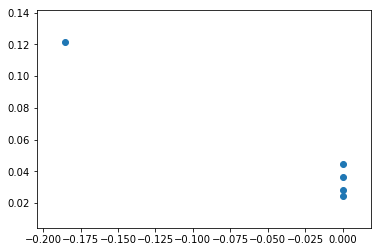

In [ ]:
# посмотрим продукты на плоскости риск-доходность:

plt.scatter(points2[0,:], points2[1,:])
plt.show()

In [ ]:
%%time

flag = 1

for counter in range(10):
    
    r = (counter + 1) / 200
    

    def mirr(wghts):
        a1 = (payoffs*wghts).sum(axis = 2)    
        a2 = np.ones((a1.shape[0]+1,a1.shape[1]))*(-1)
        a2[1:,:] = a1
        a3 = np.array([np.irr(x) for x in np.transpose(a2)]) 
        return a3

    def func(wghts):
        a3 = mirr(wghts)
        return -(a3.mean() - r)/(a3.std())

    # задаем ограничения на веса:
    cons = ({'type': 'eq', 'fun' : lambda x: x.sum()-1},
            {'type': 'ineq','fun' : lambda x: 1 - x.max()},
            {'type': 'ineq','fun' : lambda x: x.min()})

    # начальные значения весов (всех продуктов поровну)
    x0 = np.ones(payoffs.shape[-1])/payoffs.shape[-1]
    res = minimize(func, x0, method='SLSQP', options={'disp': True}, constraints=cons)

    if flag == 1:
        flag = 0
        optimals = res.x
    else:
        optimals = np.c_[optimals, res.x]

    print('Done: %i or of %i' %(counter+1, 20))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.4877903273416282
            Iterations: 7
            Function evaluations: 51
            Gradient evaluations: 7
Done: 1 or of 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.3306269653417535
            Iterations: 6
            Function evaluations: 43
            Gradient evaluations: 6
Done: 2 or of 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.199628178943283
            Iterations: 8
            Function evaluations: 57
            Gradient evaluations: 8
Done: 3 or of 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.1047563193892878
            Iterations: 9
            Function evaluations: 76
            Gradient evaluations: 9
Done: 4 or of 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1

In [ ]:
print('weights:')
with np.printoptions(precision=3, suppress=True):
    print(res.x)


In [ ]:
plt.scatter(points1[0,:], points1[1,:], c='blue')
plt.scatter(mirr(res.x).std(), mirr(res.x).mean(), c='red')

for i, txt in enumerate(names):
    plt.annotate(txt, (points1[0,i], points1[1,i]))
plt.show()

In [ ]:
plt.hist(payoffs[:,:,-1].sum(axis = 0), bins = 100)
plt.show()

In [ ]:
d